In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.1 MB/s eta 0:00:00


In [3]:
# Повторно загружаем присланный файл
file_path = r'/content/Данные_для_курсовои_Классическое_МО.xlsx'
xls = pd.ExcelFile(file_path)

# Смотрим, какие листы есть в Excel-файле
xls.sheet_names

['Sheet1']

In [4]:
df = xls.parse('Sheet1')
print(df.head())

   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0  ...           0           

In [5]:
df.info()  # показывает количество строк, пропуски, типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Columns: 214 entries, Unnamed: 0 to fr_urea
dtypes: float64(107), int64(107)
memory usage: 1.6 MB


'Unnamed: 0' —  это колонка индекса из Excel. Её можно удалить:

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df = df.drop(columns=["Unnamed: 0"], errors='ignore')
df = df.dropna(subset=["SI"])

X = df.drop(columns=["SI", "IC50, mM", "CC50, mM"], errors='ignore')
y = df["SI"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Количество строк с хотя бы одним NaN
n_missing_train = X_train.isna().any(axis=1).sum()
n_missing_test = X_test.isna().any(axis=1).sum()

print(f"Строк с NaN в X_train: {n_missing_train}")
print(f"Строк с NaN в X_test: {n_missing_test}")

Строк с NaN в X_train: 2
Строк с NaN в X_test: 1


In [11]:
# удаляем столбцы, в которых более 70% значений нулевые
threshold = 0.7  # 70%
zero_ratio = (df == 0).mean(axis=0)  # доля нулей в каждом столбце
cols_to_drop = zero_ratio[zero_ratio >= threshold].index
df = df.drop(columns=cols_to_drop)

In [12]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.3 MB/s eta 0:00:00


In [13]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 30.8 MB/s eta 0:00:00


In [14]:
# Считаем медианы по обучающему набору
medians = X_train.median()

# Заполняем NaN в train/test медианами из train
X_train = X_train.fillna(medians)
X_test = X_test.fillna(medians)

In [15]:
print("NaN в X_train:", X_train.isna().sum().sum())
print("NaN в X_test:", X_test.isna().sum().sum())

NaN в X_train: 0
NaN в X_test: 0


In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import optuna
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


# Список моделей и базовые параметры
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": make_pipeline(StandardScaler(), SVR()),
    "KNN": make_pipeline(StandardScaler(), KNeighborsRegressor()),
    "XGBoost": XGBRegressor()
}

# Функция расчёта метрик
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Прогон всех моделей
results = [evaluate_model(name, model, X_train, X_test, y_train, y_test)
           for name, model in models.items()]

results_df = pd.DataFrame(results).sort_values("RMSE")

In [ ]:
results_df

,Model,RMSE,MAE,R2
3,RandomForest,459.972767,287.955915,0.591909
4,GradientBoosting,464.675679,295.870847,0.583521
7,XGBoost,474.431531,278.384541,0.565850
6,KNN,486.813877,292.034534,0.542892
2,Lasso,523.473925,366.447737,0.471454
1,Ridge,526.019977,366.238116,0.466300
0,LinearRegression,568.264104,372.852812,0.377136
5,SVR,759.039568,503.497017,-0.111276


# Модель: Random Forest для CC50

In [17]:
# Создаём гиперпараметры для можели Random Forest
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # без 'auto'
    }
    model = RandomForestRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")
    return -score.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=300)

# Находим лучшие параметры
best_params = study.best_params
best_score = study.best_value
# Обучаем финальную модель с лучшими параметрами
final_model = RandomForestRegressor(random_state=42, **best_params)
final_model.fit(X_train, y_train)

[I 2025-06-17 15:56:34,491] A new study created in memory with name: no-name-26a746d6-0518-443f-ade6-4f709e784062
[I 2025-06-17 15:56:42,790] Trial 0 finished with value: 251.35183467590596 and parameters: {'n_estimators': 171, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 0 with value: 251.35183467590596.
[I 2025-06-17 15:56:43,520] Trial 1 finished with value: 249.14531555048598 and parameters: {'n_estimators': 135, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 249.14531555048598.
[I 2025-06-17 15:57:00,797] Trial 2 finished with value: 252.77854102480913 and parameters: {'n_estimators': 223, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 249.14531555048598.
[I 2025-06-17 15:57:01,407] Trial 3 finished with value: 250.82523859909625 and parameters: {'n_estimators': 107, 'max_depth': 19, 'min

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=9,
                      min_samples_split=18, n_estimators=271, random_state=42)

In [18]:
# Обучаем финальную модель с лучшими параметрами
final_model = RandomForestRegressor(random_state=42, **best_params)
final_model.fit(X_train, y_train)

# ВАЖНО: согласовать столбцы X_test с X_train
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)
y_pred = final_model.predict(X_test_aligned)

# Метрики
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

MAE: 194.02, RMSE: 1369.27, R²: 0.067


# Визуализация, какие признаки наиболее важны(feature importance)

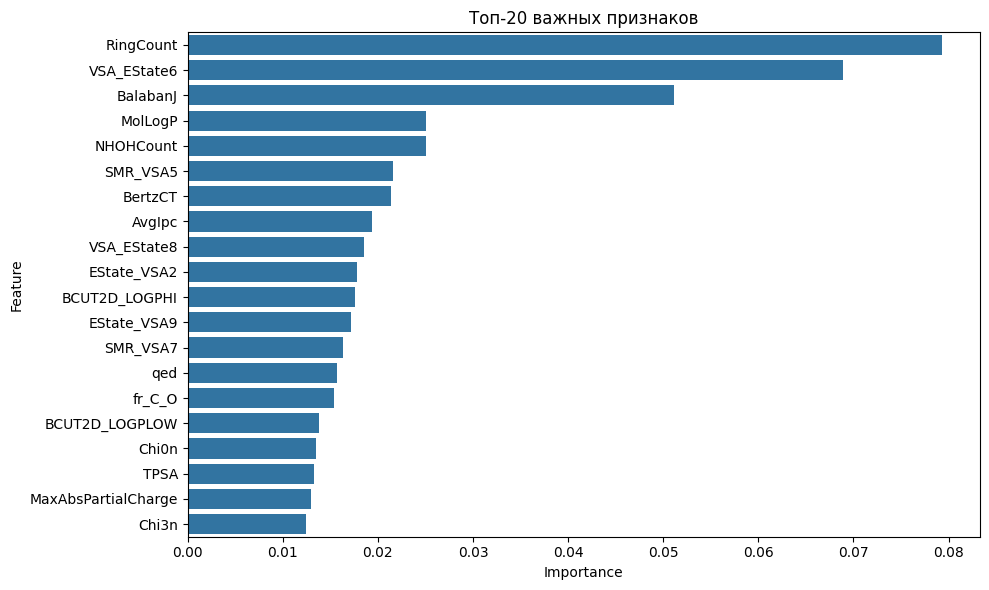

In [19]:
# importance для RandomForest
importances = final_model.feature_importances_
feature_names = X_train.columns

# Сформировать DataFrame и отсортировать по убыванию
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(20), x='Importance', y='Feature')
plt.title('Топ-20 важных признаков')
plt.tight_layout()
plt.show()

# Теперь проверяем результат с GridSearchCV

In [22]:
# Копия датафрейма и удаление 'CC50' и 'SI' — чтобы они не помогали предсказанию IC50
X = df.drop(columns=["SI", "IC50, mM", "CC50, mM"], errors='ignore')
y = df["SI"]

# Разделим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Пример минимальной очистки
df = df.dropna(how='all', axis=1)  # удалить пустые столбцы
df = df.fillna(medians)  # заменить NaN на медианы

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 13, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_grid_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV RMSE: 250.29256246509627


In [25]:
# Предсказание
y_pred = best_grid_model.predict(X_test)

# Метрики
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final RMSE: {rmse:.3f}")
print(f"Final MAE: {mae:.3f}")
print(f"Final R²:  {r2:.3f}")


Final RMSE: 1360.928
Final MAE: 192.027
Final R²:  0.078


# Выводим топ-20 признаков по важности

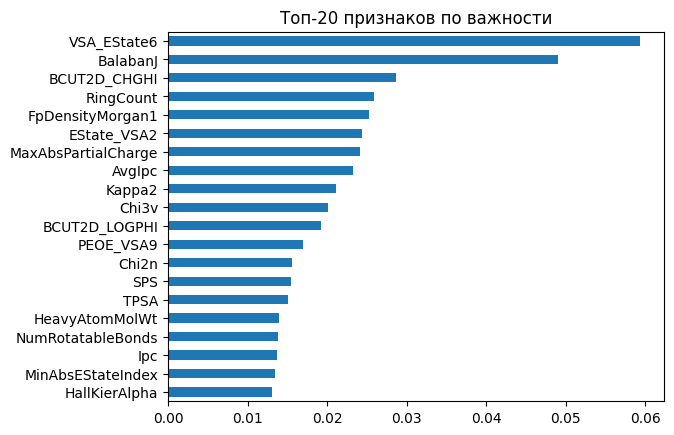

In [26]:
feature_importances = pd.Series(best_grid_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Топ-20 признаков по важности")
plt.gca().invert_yaxis()
plt.show()